# __Predicting Property Price From Location, Neighborhood And Area In Buenos Aires Dataset__

In [72]:
import warnings
from glob import glob

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

# __Data import and Preprocessing__

In [73]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get neighborhood column from place with parent names
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    # drop place with parent names column
    df.drop(columns="place_with_parent_names", inplace=True)
    # drop other columns
    df.drop(columns=["floor", "expenses"], inplace=True)
    df.drop(columns =["operation","currency", "property_type", "properati_url"], inplace=True)
    df.drop(columns = [
        'price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2'
    ], inplace=True)
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
   
    return df

In [74]:
# load file using glob
files = glob("../data/buenos-aires-real-estate-*.csv")
files

['../data\\buenos-aires-real-estate-1.csv',
 '../data\\buenos-aires-real-estate-2.csv',
 '../data\\buenos-aires-real-estate-3.csv',
 '../data\\buenos-aires-real-estate-4.csv',
 '../data\\buenos-aires-real-estate-5.csv']

In [75]:
# wrangle files using list comprehension
frames = [wrangle(file) for file in files]

In [76]:
# concatenating files
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


## Exploratory Data Analysis

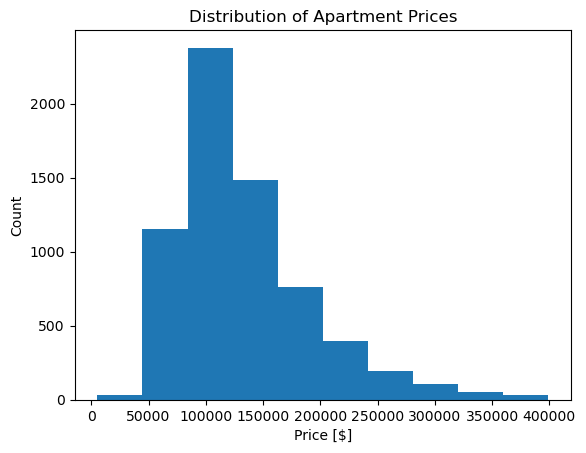

In [95]:
fig, ax = plt.subplots() 

# Plot the histogram on the axes object
ax.hist(df["price_aprox_usd"]) 

# Label axes using the axes 
ax.set_xlabel("Price [$]")
ax.set_ylabel("Count")


# Add title 
ax.set_title("Distribution of Apartment Prices");
fig.savefig("../Visuals/price_distribution.png", dpi=300, bbox_inches="tight")

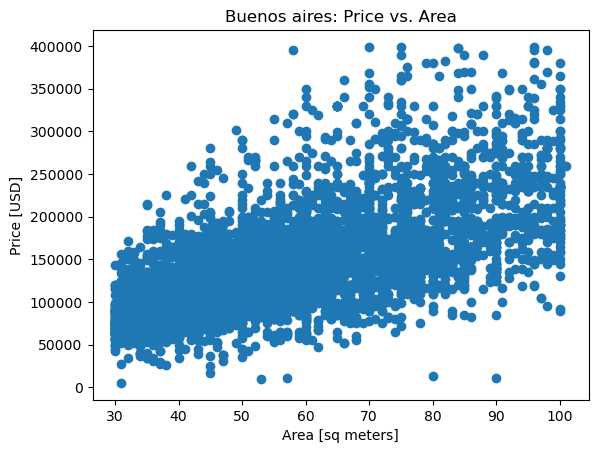

In [97]:
fig, ax = plt.subplots() 

# Create the scatter plot on the axes object
ax.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"]) 

# Label axes 
ax.set_xlabel("Area [sq meters]")
ax.set_ylabel("Price [USD]")

#  Add title 
ax.set_title("Buenos aires: Price vs. Area");
fig.savefig("../visuals/price_vs_area.png", dpi=300, bbox_inches="tight")

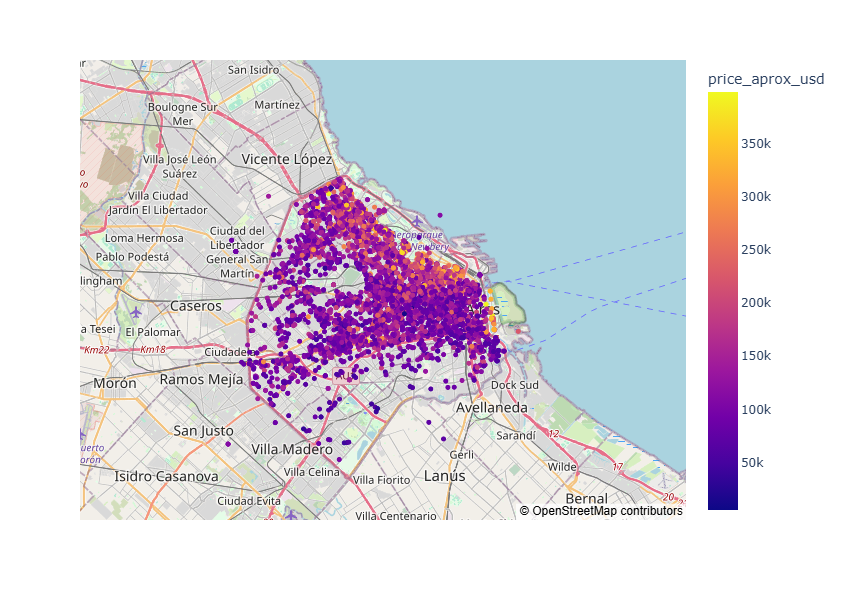

In [100]:
# Plot Mapbox location and price
warnings.filterwarnings("ignore")
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=600,
    height=600,
    color="price_aprox_usd",
    zoom= 10,
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()



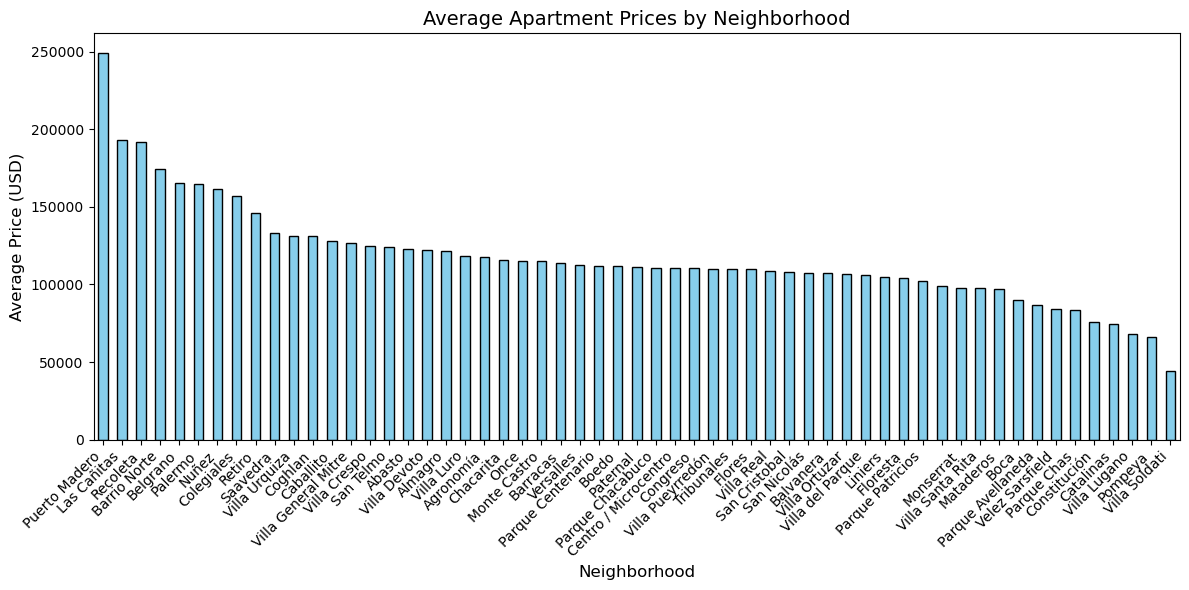

In [103]:

# Group and sort the data
mean_price_neighborhood = df.groupby("neighborhood")["price_aprox_usd"].mean().sort_values(ascending=False)

# Plot
fig = plt.figure(figsize=(12, 6))  
mean_price_neighborhood.plot(kind="bar", color="skyblue", edgecolor="black")

plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.title("Average Apartment Prices by Neighborhood", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

fig.savefig("../visuals/neighborhood_price_bar.png", dpi=300, bbox_inches="tight")
plt.show()


# __Model Building__

In [81]:
# set my feature matrix and target vector
target = "price_aprox_usd"
features = ["surface_covered_in_m2","lat","lon", "neighborhood"]
X_train = df[features]
y_train = df[target]

In [82]:
# make baseline model and evaluate using mean absolute error
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


In [83]:
# create pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,['neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


In [84]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.107190330145


In [85]:
X_test = pd.read_csv("../data/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

## Prediction Function

In [86]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat":lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df= pd.DataFrame(data, index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [87]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

## Interactive MVP

In [88]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…